# Export to PettingZoo API

Here, we demonstrate that the API of Pgx is sufficiently general by translating it to the AEC API of PettingZoo. However, please note that this conversion is merely a demonstration of generality, and it should be noted that efficiency through parallel execution is lost with this conversion.

In [1]:
!pip install pgx pettingzoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.7/321.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.7/826.7 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 50.5 MB/s eta 0:00:00


In [2]:
import sys
from typing import Literal, Optional

import jax
import jax.numpy as jnp
import numpy as np
from gymnasium import spaces
from IPython.display import display_svg
from pettingzoo.utils import wrappers
import pgx
import pettingzoo

print(f"{pgx.__version__=}")
print(f"{pettingzoo.__version__=}")

pgx.__version__='0.8.0'
pettingzoo.__version__='1.23.1'


## Define converter to PettingZoo environment

In [3]:
def pettingzoo_env(env_id: pgx.EnvId) -> pettingzoo.AECEnv:
    env = PettingZooEnv(env_id)
    env = wrappers.TerminateIllegalWrapper(env, illegal_reward=-1)
    env = wrappers.AssertOutOfBoundsWrapper(env)
    env = wrappers.OrderEnforcingWrapper(env)
    return env


class PettingZooEnv(pettingzoo.AECEnv):
    metadata = {
        "render_modes": ["svg"],
    }

    def __init__(self, env_id: pgx.EnvId, render_mode=None):
        super().__init__()

        # prepare Pgx env attributes
        pgx_env: pgx.Env = pgx.make(env_id)
        self._num_players = pgx_env.num_players
        self._init_fn = jax.jit(pgx_env.init)
        self._step_fn = jax.jit(pgx_env.step)
        self._observe_fn = jax.jit(pgx_env.observe)
        self._state: pgx.State = self._init_fn(jax.random.PRNGKey(0))

        # prepare PettingZoo API attributes
        self.agents = [f"player_{i}" for i in range(pgx_env.num_players)]
        self.action_spaces = {i: spaces.Discrete(pgx_env.num_actions) for i in self.agents}
        self.observation_spaces = {
            i: spaces.Dict(
                {
                    "observation": spaces.Box(
                        low=0, high=1, shape=pgx_env.observation_shape, dtype=np.int8
                    ),
                    "action_mask": spaces.Box(
                        low=0, high=1, shape=(pgx_env.num_actions,), dtype=np.int8
                    ),
                }
            )
            for i in self.agents
        }        
        self.possible_agents = self.agents[:]
        self.rewards = {i: 0 for i in self.agents}
        self.terminations = {i: False for i in self.agents}
        self.truncations = {i: False for i in self.agents}
        self.infos = {i: {} for i in self.agents}  # type: ignore
        self.agent_selection = f"player_{self._state.current_player}"
        self.render_mode = render_mode

    def observe(self, agent):
        if agent == self.agent_selection:
            obs = self._state.observation
        else:
            obs = self.observe_fn(self._state, int(agent.split("_")[-1]))
        return {
            "observation": np.float32(obs),
            "action_mask": np.int8(self._state.legal_action_mask),
        }

    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def action_space(self, agent):
        return self.action_spaces[agent]

    def step(self, action):
        if (
            self.terminations[self.agent_selection]
            or self.truncations[self.agent_selection]
        ):
            return self._was_dead_step(action)

        self._state = self._step_fn(self._state, jnp.int32(action))
        next_agent = f"player_{self._state.current_player}"
        for i in range(self._num_players):
            self.rewards[f"player_{i}"] = float(self._state.rewards[i])        
        
        if self._state.terminated:
            self.terminations = {i: True for i in self.agents}
        
        self._cumulative_rewards[self.agent_selection] = 0
        self.agent_selection = next_agent
        self._accumulate_rewards()

    def reset(self, seed=None, options=None):
        assert seed is not None
        key = jax.random.PRNGKey(seed)
        self._state = self._init_fn(key)
        self.agents = self.possible_agents[:]
        self.rewards = {i: 0 for i in self.agents}
        self._cumulative_rewards = {i: 0 for i in self.agents}
        self.terminations = {i: False for i in self.agents}
        self.truncations = {i: False for i in self.agents}
        self.infos = {i: {} for i in self.agents}
        self.agent_selection = f"player_{self._state.current_player}"

    def render(self):
        if "ipykernel" not in sys.modules:
            raise RuntimeError("Svg rendering only supports jupyter notebook")
        display_svg(self._state._repr_html_(), raw=True)

    def close(self):
        ...

## Run Tic-tac-toe random play

In [4]:
def random_play(env_id, seed=9999):
    env = pettingzoo_env(env_id)
    env.reset(seed=seed)

    for agent in env.agent_iter():
        env.render()
        observation, reward, termination, truncation, info = env.last()
    
        if termination or truncation:
            action = None
        else: 
            mask = observation["action_mask"]
            action = np.random.choice(np.where(observation["action_mask"])[0])
            action = env.action_space(agent).sample(mask)

        print(f"{reward=}")
        print(f"{action=}")

        env.step(action)

    env.render()
    env.close()

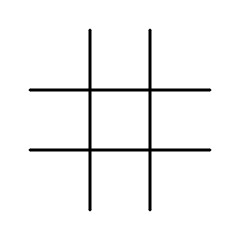

reward=0
action=1


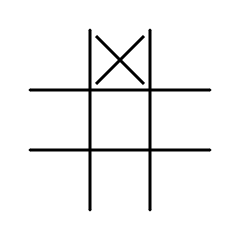

reward=0.0
action=4


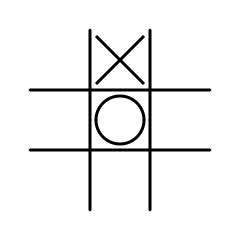

reward=0.0
action=0


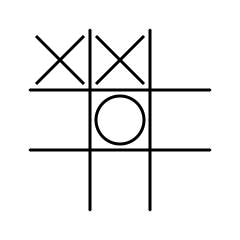

reward=0.0
action=2


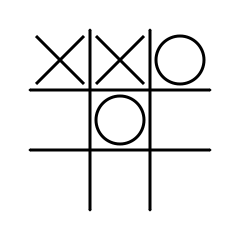

reward=0.0
action=6


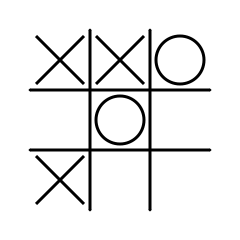

reward=0.0
action=5


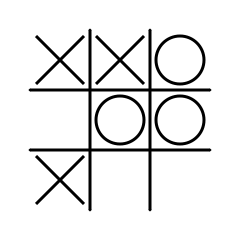

reward=0.0
action=8


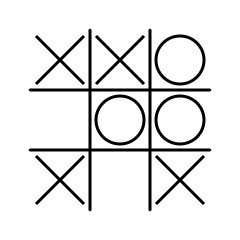

reward=0.0
action=7


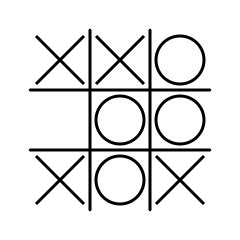

reward=0.0
action=3


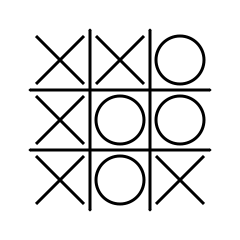

reward=-1.0
action=None


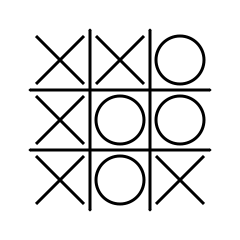

reward=1.0
action=None


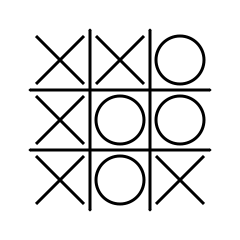

In [5]:
random_play("tic_tac_toe")

## Try other games in Pgx

In [6]:
pgx.available_envs()

('2048',
 'animal_shogi',
 'backgammon',
 'chess',
 'connect_four',
 'gardner_chess',
 'go_9x9',
 'go_19x19',
 'hex',
 'kuhn_poker',
 'leduc_holdem',
 'minatar-asterix',
 'minatar-breakout',
 'minatar-freeway',
 'minatar-seaquest',
 'minatar-space_invaders',
 'othello',
 'shogi',
 'sparrow_mahjong',
 'tic_tac_toe')

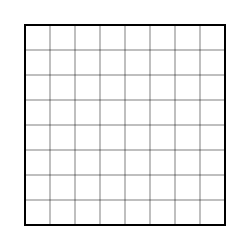

reward=0
action=16


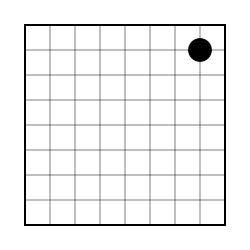

reward=0.0
action=0


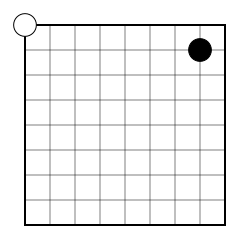

reward=0.0
action=26


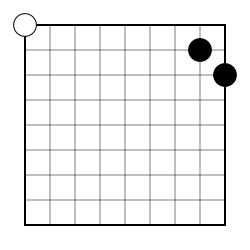

reward=0.0
action=9


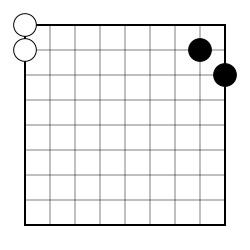

reward=0.0
action=5


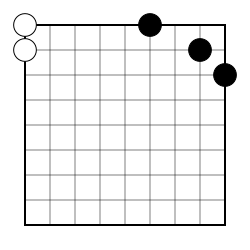

reward=0.0
action=13


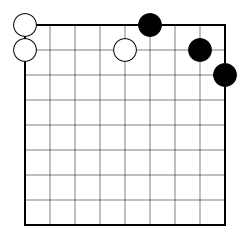

reward=0.0
action=14


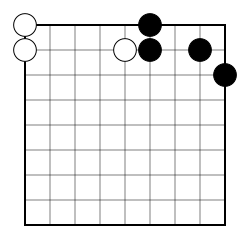

reward=0.0
action=25


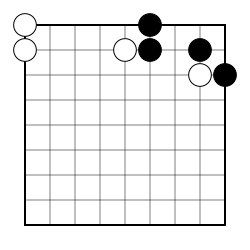

reward=0.0
action=22


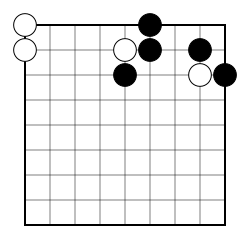

reward=0.0
action=23


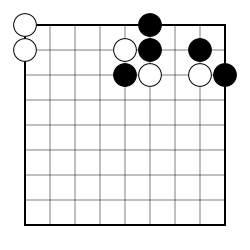

reward=0.0
action=7


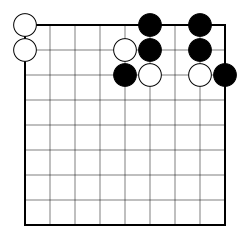

reward=0.0
action=34


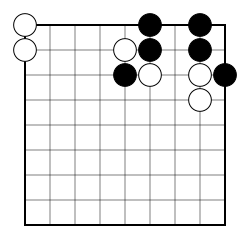

reward=0.0
action=42


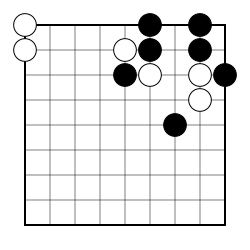

reward=0.0
action=12


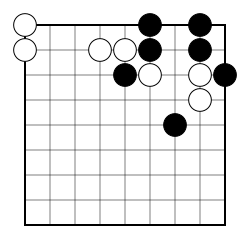

reward=0.0
action=55


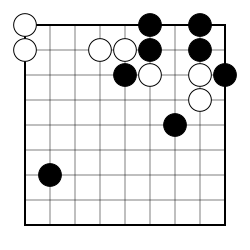

reward=0.0
action=17


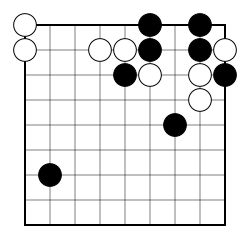

reward=0.0
action=81


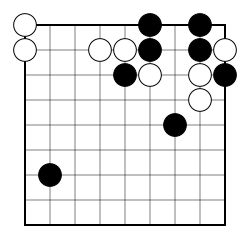

reward=0.0
action=32


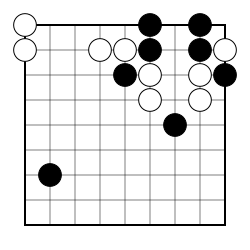

reward=0.0
action=50


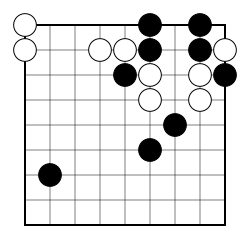

reward=0.0
action=71


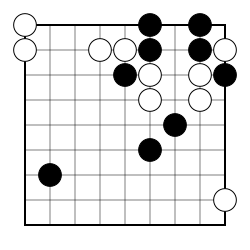

reward=0.0
action=18


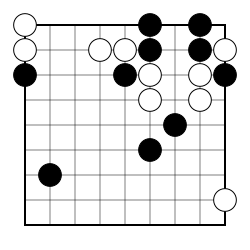

reward=0.0
action=56


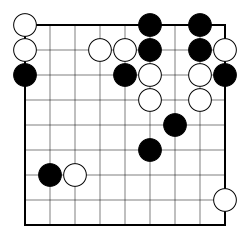

reward=0.0
action=45


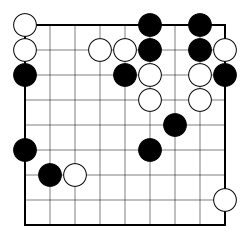

reward=0.0
action=80


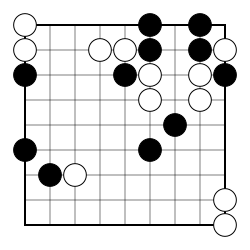

reward=0.0
action=66


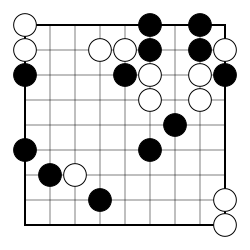

reward=0.0
action=39


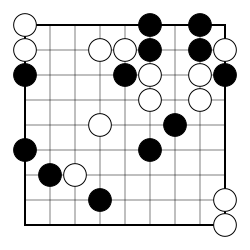

reward=0.0
action=70


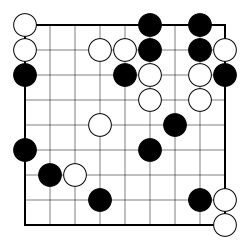

reward=0.0
action=63


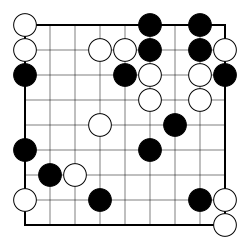

reward=0.0
action=46


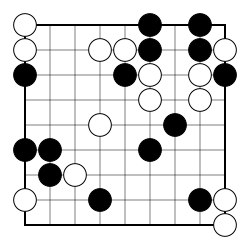

reward=0.0
action=44


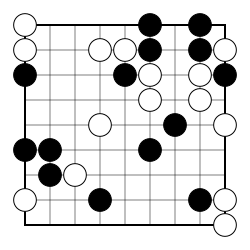

reward=0.0
action=38


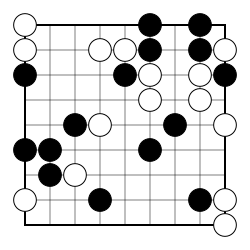

reward=0.0
action=67


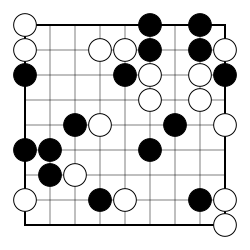

reward=0.0
action=76


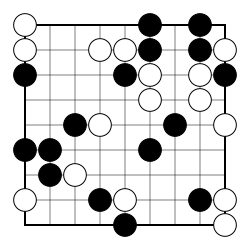

reward=0.0
action=6


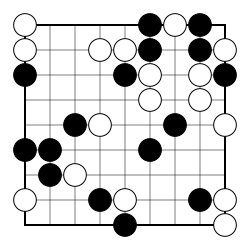

reward=0.0
action=61


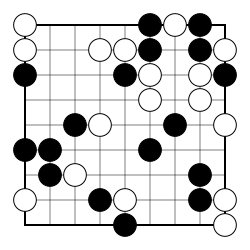

reward=0.0
action=19


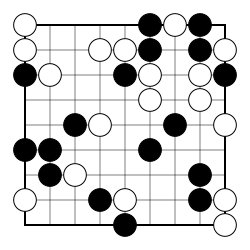

reward=0.0
action=79


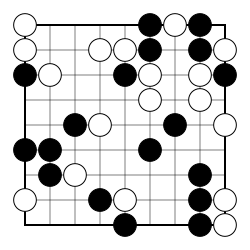

reward=0.0
action=54


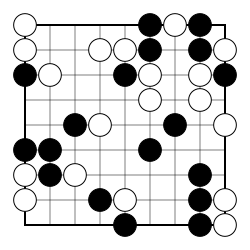

reward=0.0
action=77


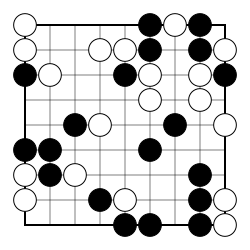

reward=0.0
action=51


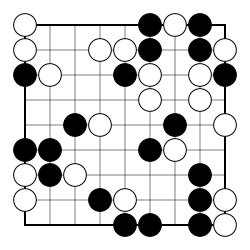

reward=0.0
action=72


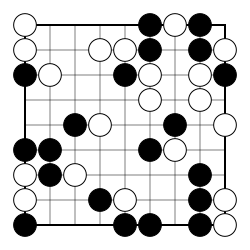

reward=0.0
action=10


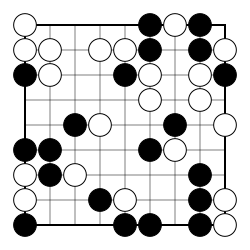

reward=0.0
action=36


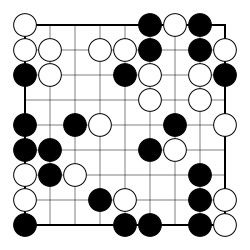

reward=0.0
action=11


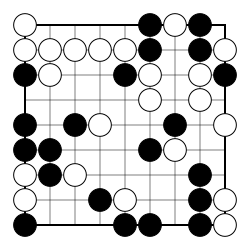

reward=0.0
action=28


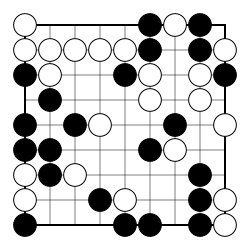

reward=0.0
action=35


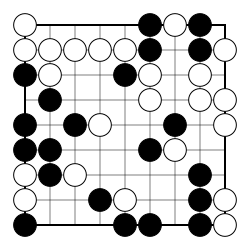

reward=0.0
action=47


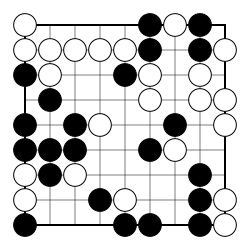

reward=0.0
action=21


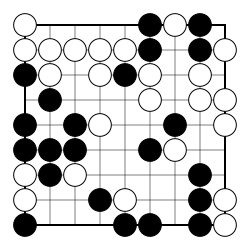

reward=0.0
action=49


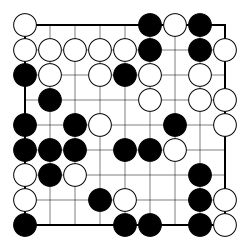

reward=0.0
action=43


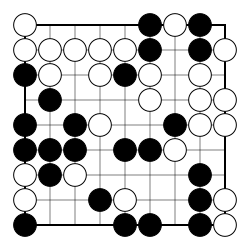

reward=0.0
action=53


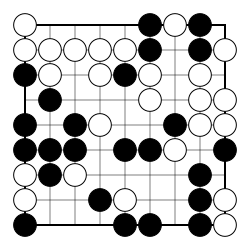

reward=0.0
action=4


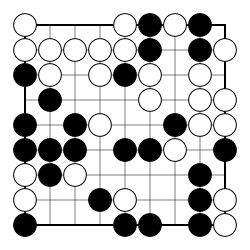

reward=0.0
action=64


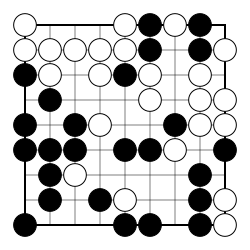

reward=0.0
action=54


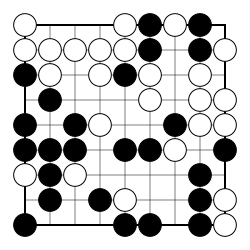

reward=0.0
action=41


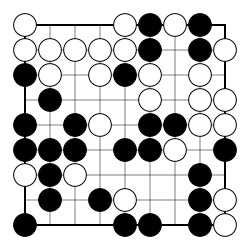

reward=0.0
action=75


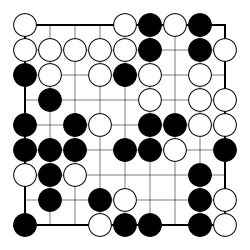

reward=0.0
action=37


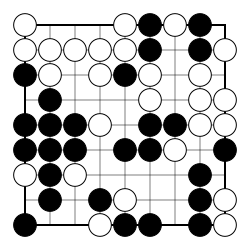

reward=0.0
action=30


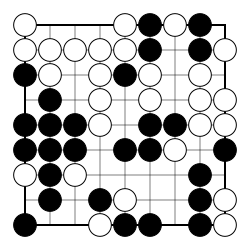

reward=0.0
action=20


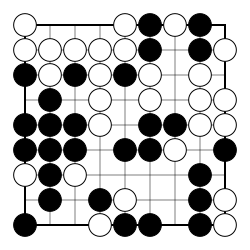

reward=0.0
action=26


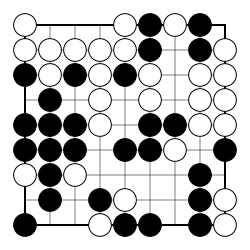

reward=0.0
action=8


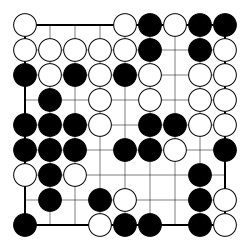

reward=0.0
action=33


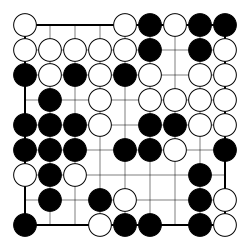

reward=0.0
action=60


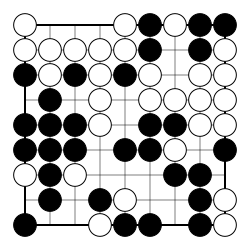

reward=0.0
action=3


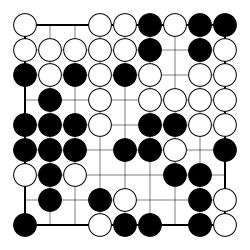

reward=0.0
action=57


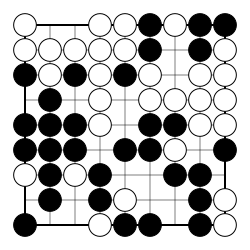

reward=0.0
action=27


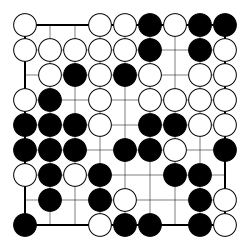

reward=0.0
action=63


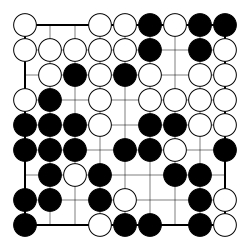

reward=0.0
action=59


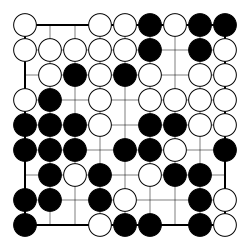

reward=0.0
action=54


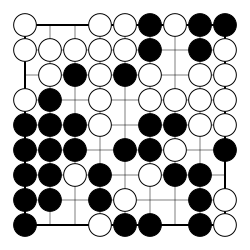

reward=0.0
action=81


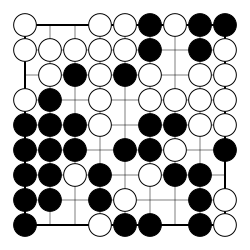

reward=0.0
action=31


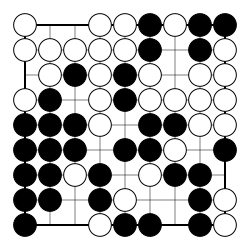

reward=0.0
action=18


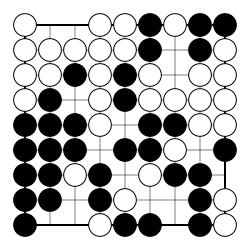

reward=0.0
action=68


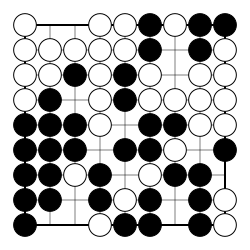

reward=0.0
action=29


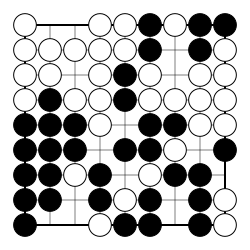

reward=0.0
action=52


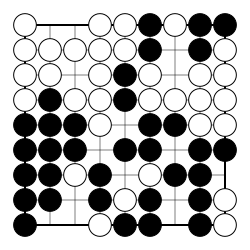

reward=0.0
action=1


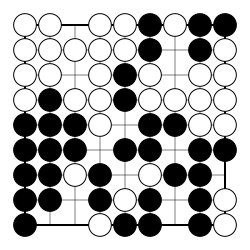

reward=0.0
action=40


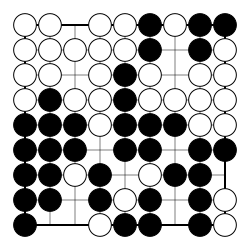

reward=0.0
action=73


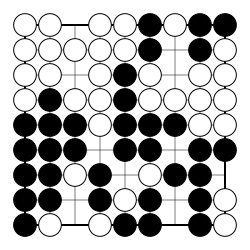

reward=0.0
action=48


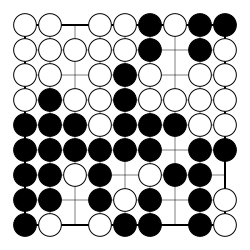

reward=0.0
action=78


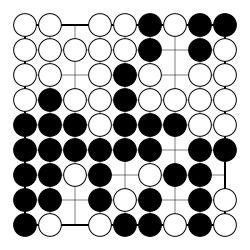

reward=0.0
action=15


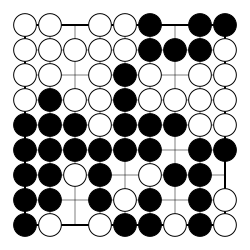

reward=0.0
action=69


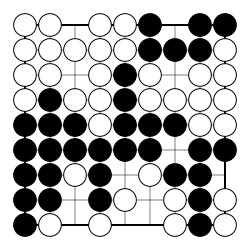

reward=0.0
action=68


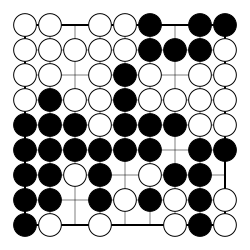

reward=0.0
action=65


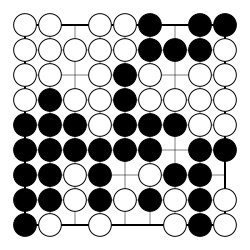

reward=0.0
action=76


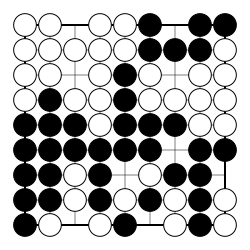

reward=0.0
action=77


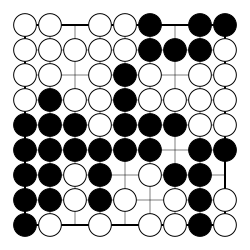

reward=0.0
action=81


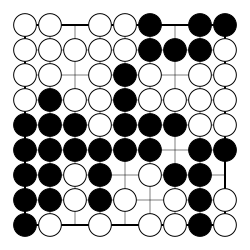

reward=0.0
action=58


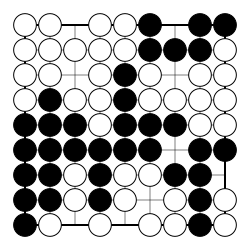

reward=0.0
action=6


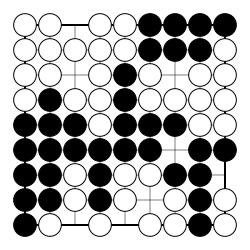

reward=0.0
action=2


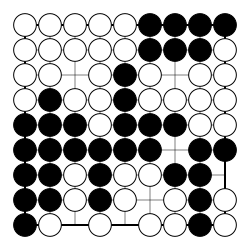

reward=0.0
action=24


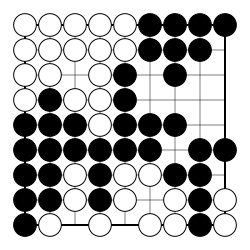

reward=0.0
action=43


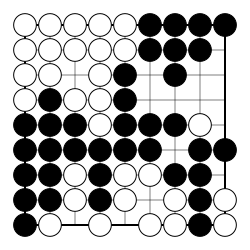

reward=0.0
action=17


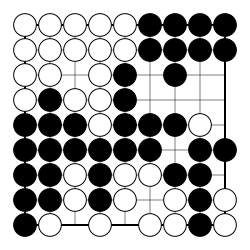

reward=0.0
action=76


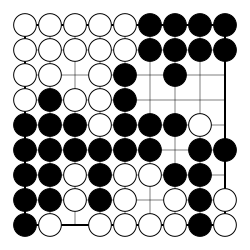

reward=0.0
action=44


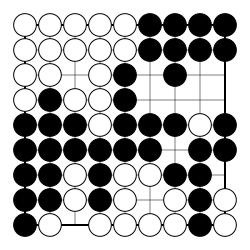

reward=0.0
action=68


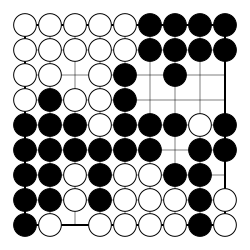

reward=0.0
action=81


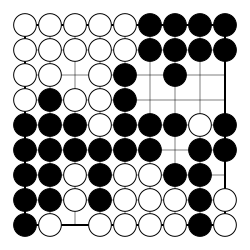

reward=0.0
action=25


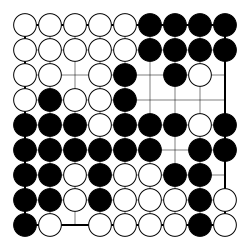

reward=0.0
action=20


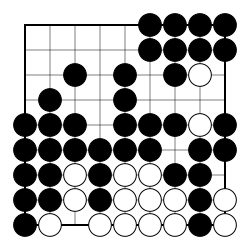

reward=0.0
action=4


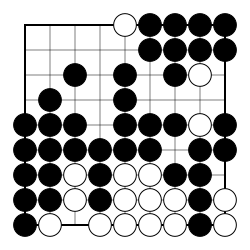

reward=0.0
action=30


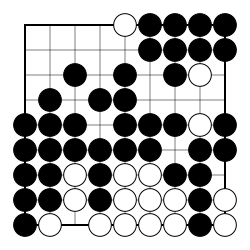

reward=0.0
action=32


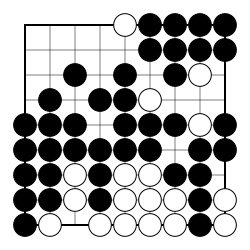

reward=0.0
action=33


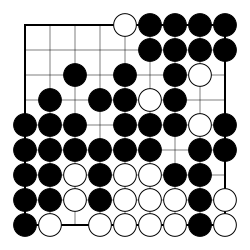

reward=0.0
action=34


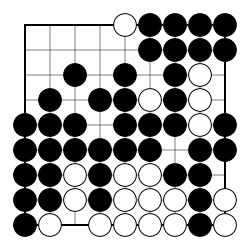

reward=0.0
action=81


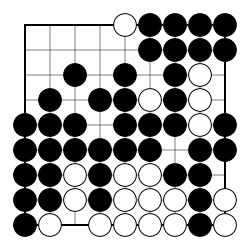

reward=0.0
action=18


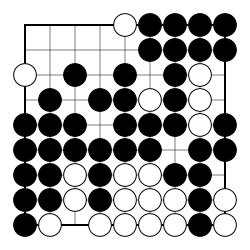

reward=0.0
action=29


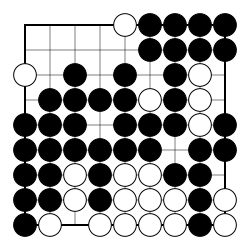

reward=0.0
action=12


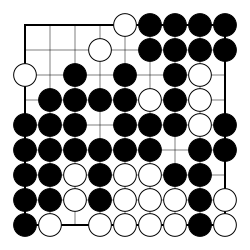

reward=0.0
action=35


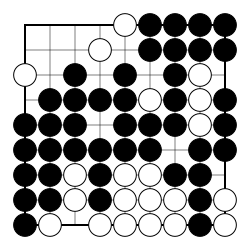

reward=0.0
action=11


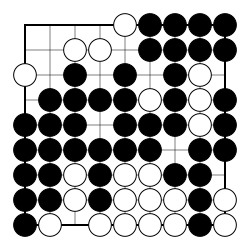

reward=0.0
action=21


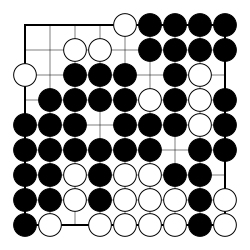

reward=0.0
action=81


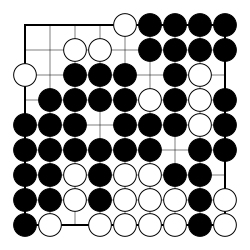

reward=0.0
action=0


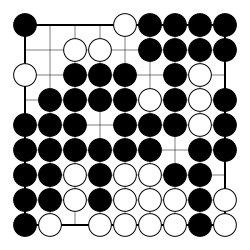

reward=0.0
action=27


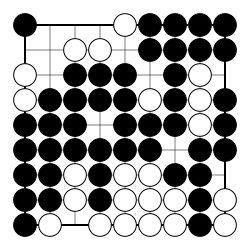

reward=0.0
action=51


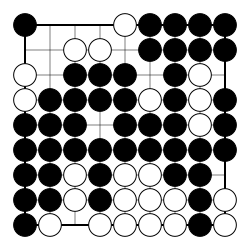

reward=0.0
action=3


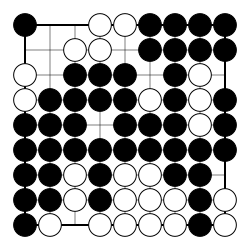

reward=0.0
action=9


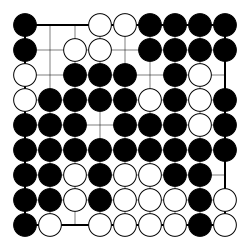

reward=0.0
action=2


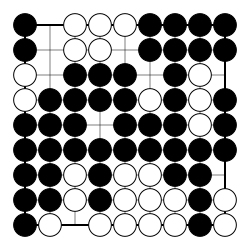

reward=0.0
action=62


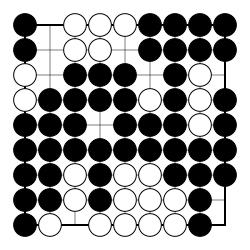

reward=0.0
action=81


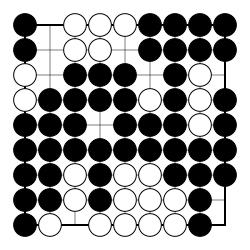

reward=0.0
action=26


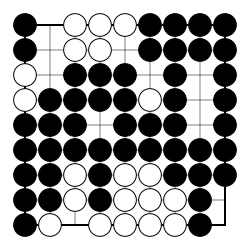

reward=0.0
action=43


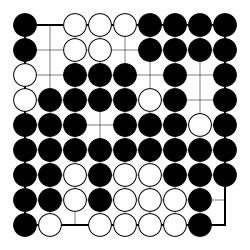

reward=0.0
action=81


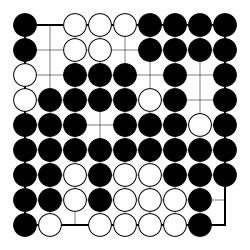

reward=0.0
action=71


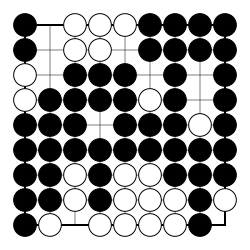

reward=0.0
action=23


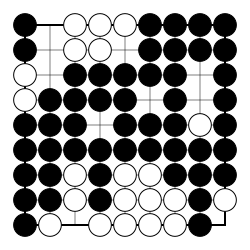

reward=0.0
action=19


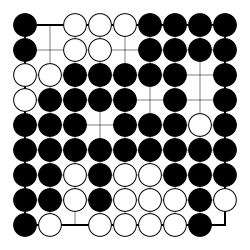

reward=0.0
action=80


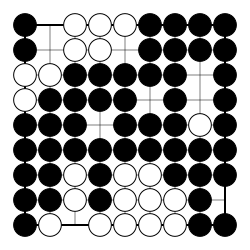

reward=0.0
action=10


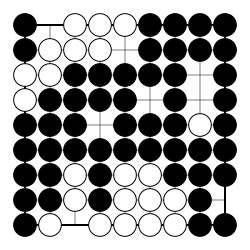

reward=0.0
action=81


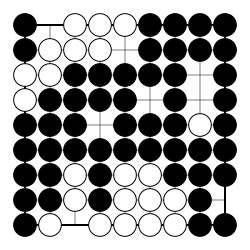

reward=0.0
action=81


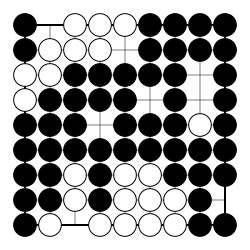

reward=1.0
action=None


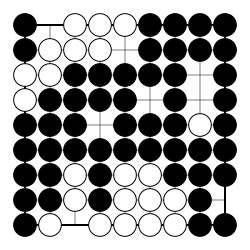

reward=-1.0
action=None


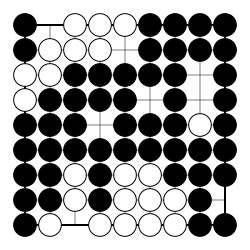

In [7]:
random_play("go_9x9")